In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [22]:
trainEND = '2019-12-31'
testSTART = '2020-01-01'

In [3]:
import datetime

# принимает строку, приращивает дату, возвращает строку
# по умолчанию возвращает следующий день
def NextDay(date_str, delta=1):
    date_time = datetime.datetime.strptime(date_str, "%Y-%m-%d").date() + datetime.timedelta(days=delta)
    return date_time.strftime("%Y-%m-%d")

In [7]:
df = pd.read_csv('../data/mvp_data.csv', parse_dates=True, index_col=0)
tickers = ['EUR', 'GOLD', 'Bitcoin', 'Apple', 'Exxon', 'VISA', 'Oil']
df.columns = tickers
# заполним пропуски последними известными значениями, так как пропуски чаще всего - это праздничные периоды
# перейдем на недельный интервал и средним значениям на них
df_w = df.fillna(method='ffill').resample('W').ffill()
df_w_pct = df_w.pct_change().iloc[1:] # отнсительные изменения к предыдущей неделе
df_w_log = np.log(df_w/df_w.shift(1)).iloc[1:] # переходим к логдоходности
df_w_log.head()

,EUR,GOLD,Bitcoin,Apple,Exxon,VISA,Oil
Date,,,,,,,
2015-01-11,-0.024564,0.024980,-0.081387,0.024217,-0.007895,-0.017087,-0.085753
2015-01-18,-0.013544,0.048869,-0.333282,-0.055243,-0.010698,-0.021651,0.006801
2015-01-25,-0.025291,0.012220,0.112515,0.063866,-0.002527,0.013016,-0.065785
2015-02-01,-0.000987,-0.010968,-0.028105,0.036330,-0.038926,-0.013172,0.056500
2015-02-08,0.011962,-0.035508,-0.018539,0.014995,0.045615,0.047910,0.069076


In [8]:
train_df = df_w_log[:trainEND] # TRAIN 2015-2019
test_df = df_w_log[testSTART:] # TEST 2020-2022

In [10]:
assetsNum = len(df.columns)
period_ret = 52 # для перехода от недельной к годовой доходности
iterNum = 10000

all_portf = np.zeros((iterNum, assetsNum)) # все портфели
ret_arr = np.zeros(iterNum) # доходность
vol_arr = np.zeros(iterNum) # волатильность для оценки риска
sharpe_arr = np.zeros(iterNum)

for x in range(iterNum):
    portf = np.array(np.random.random(assetsNum))
    portf = portf/np.sum(portf)
    
    all_portf[x,:] = portf
    
    ret_arr[x] = np.sum((train_df.mean()*portf*period_ret))
    
    vol_arr[x] = np.sqrt(np.dot(portf.T, np.dot(train_df.cov()*period_ret, portf)))
    
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [11]:
max_sharpe_portf = sharpe_arr.argmax()
max_sharpe_ret = ret_arr[sharpe_arr.argmax()]
max_sharpe_vol = vol_arr[sharpe_arr.argmax()]

print(sharpe_arr.max())
print(max_sharpe_portf)
print(all_portf[max_sharpe_portf, :])

1.4292387506974982
5004
[0.03988238 0.15512982 0.15849916 0.15707872 0.03611857 0.42447444
 0.02881691]


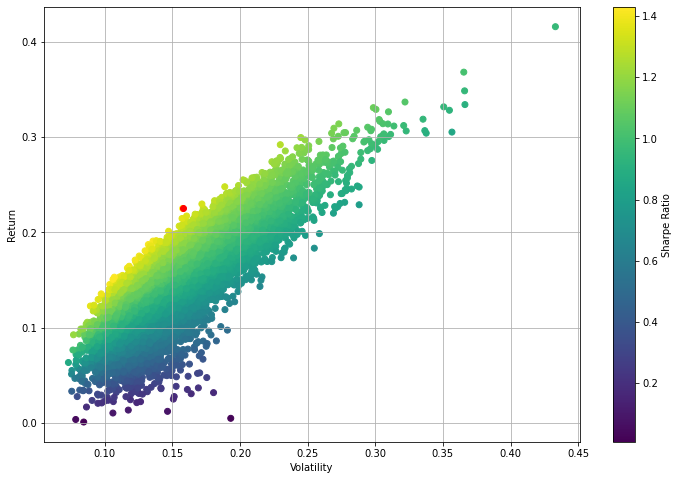

In [12]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sharpe_vol, max_sharpe_ret, c='red')
plt.grid()
plt.show()

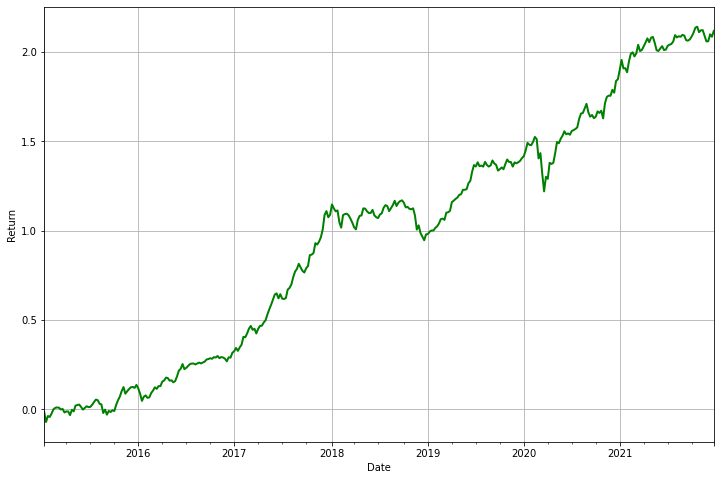

In [13]:
plt.figure(figsize=(12,8))
plt.ylabel('Return')
np.matmul(df_w_pct[:'2021-12-31'], all_portf[max_sharpe_portf, :]).cumsum().plot(color='green', linewidth=2)
plt.grid()
plt.show()

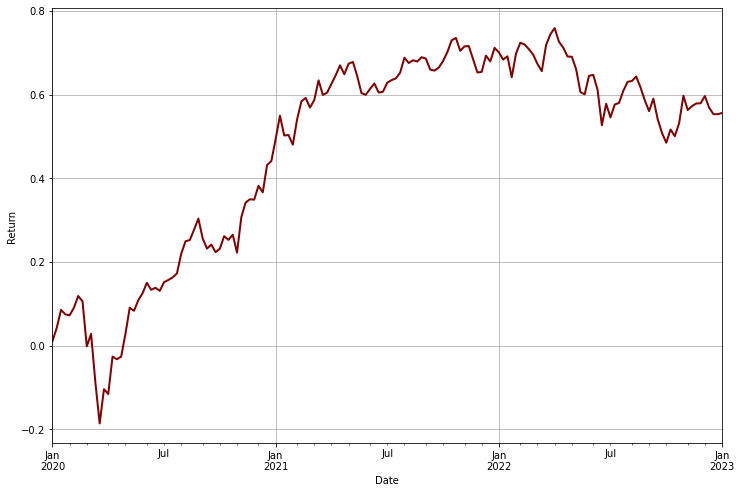

In [23]:
# бэктест
plt.figure(figsize=(12,8))
plt.ylabel('Return')
np.matmul(df_w_pct[testSTART:], all_portf[max_sharpe_portf, :]).cumsum().plot(color='maroon', linewidth=2)
plt.grid()
plt.show()

### Поиск оптимального портфеля с помощью МНК

In [15]:
# возвращает прибыль, волатильность и коэффициент Шарпа для любого портфеля
def get_params(portf):
    portf = np.array(portf)
    ret = np.sum(df_w_log.mean() * portf) * period_ret
    vol = np.sqrt(np.dot(portf.T, np.dot(df_w_log.cov()*period_ret, portf)))
    shrp = ret/vol
    return np.array([ret, vol, shrp])

# вовзращает отрицательный кэф. Шарпа, чтобы решать задачу минимизации
def neg_sharpe(portf):
    return get_params(portf)[2] * -1

# проверка на валидность: возвращает 0, если сумма равна 1
def check_valid(portf):
    return np.sum(portf) - 1

In [16]:
cons = ({'type': 'eq', 'fun': check_valid})
bounds = tuple([(0, 1) for _ in range(assetsNum)])
init_portf = [1/assetsNum for _ in range(assetsNum)]


In [17]:
# поиск оптимального портфеля с помощью МНК
from scipy.optimize import minimize
res = minimize(neg_sharpe, init_portf, method='SLSQP', bounds=bounds, constraints=cons)
print(res)

     fun: -0.9851799366291581
     jac: array([ 1.91473834e-01, -5.69745898e-05,  2.15560198e-04, -8.87662172e-05,
        4.17181231e-01,  5.72651625e-05,  3.21192577e-01])
 message: 'Optimization terminated successfully'
    nfev: 91
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([1.16371563e-17, 3.44590985e-01, 1.44060709e-01, 2.78575968e-01,
       0.00000000e+00, 2.32772338e-01, 9.89622137e-17])


In [18]:
get_params(res.x)

array([0.17694586, 0.17960766, 0.98517994])

## Визуализация границ

In [19]:
def minimize_vol(portf):
    return get_params(portf)[1]

In [20]:
frontier_x = []
frontier_y = np.linspace(0, 0.6, 200)

for y in frontier_y:
    cons = ({'type':'eq', 'fun': check_valid},
            {'type':'eq', 'fun': lambda w: get_params(w)[0] - y})
    
    result = minimize(minimize_vol, init_portf, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

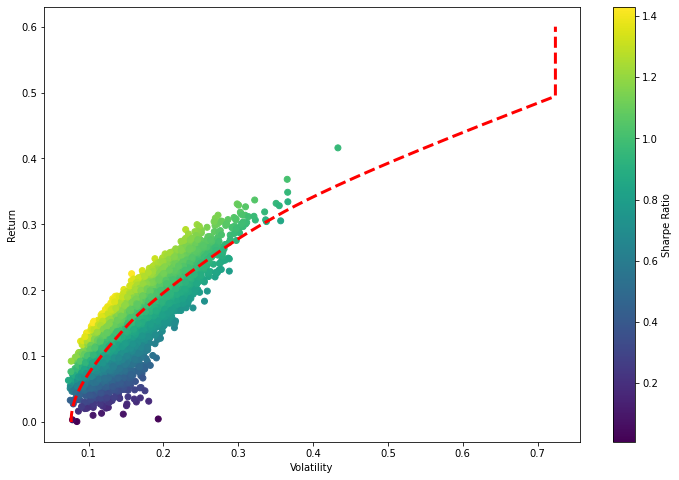

In [21]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x, frontier_y, 'r--', linewidth=3)
plt.show()

###  тут надо поработать еще с визуализацией границы, само облако портфелей рисуется нормально

In [32]:
# переделать через vol_arr, ret_arr, bounds_ef = np.arange(0, 1, 0.1), 
# = sharpe_arr.argmax() - для каждого отдельного участка
# = ret_arr[sharpe_arr.argmax()]
# = vol_arr[sharpe_arr.argmax()]
# frontier_x
# frontier_y

## Динамика по портфелю + тестирование

In [24]:
train_din = np.matmul(df_w_pct[:trainEND], res.x).cumsum() # TRAIN 2020-2021
test_din = np.matmul(df_w_pct[testSTART:], res.x).cumsum() # TEST 2022

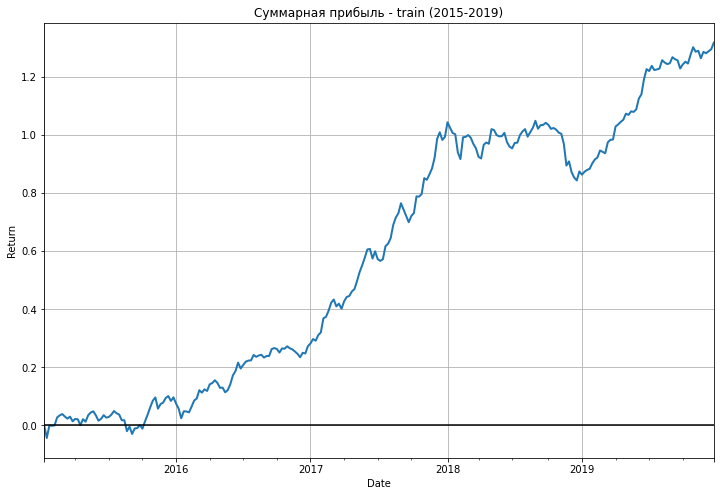

In [38]:
plt.figure(figsize=(12,8))
train_din.plot(linewidth=2)
plt.title('Суммарная прибыль - train (2015-2019)')
plt.ylabel('Return')
plt.grid()
plt.axhline(y=0, color='black')
plt.show()

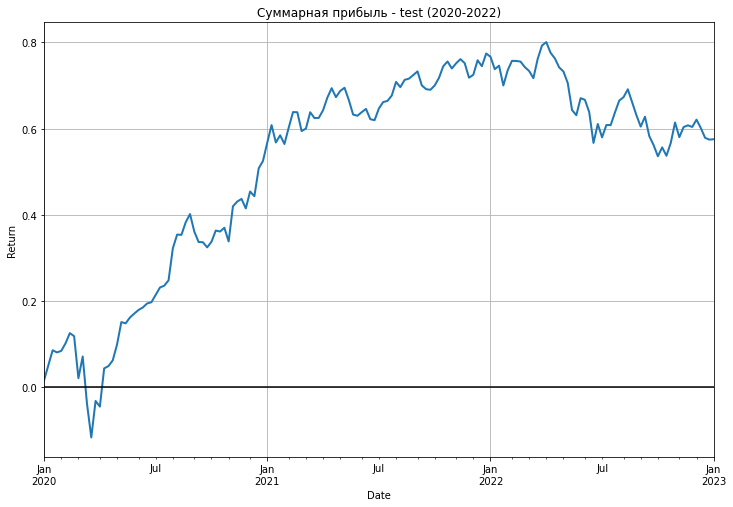

In [39]:
plt.figure(figsize=(12,8))
test_din.plot(linewidth=2)
plt.title('Суммарная прибыль - test (2020-2022)')
plt.ylabel('Return')
plt.grid()
plt.axhline(y=0, color='black')
plt.show()

In [44]:
np.matmul(df_w_pct[testSTART:], res.x).to_csv('test_results/markowitz_return_series.csv')

In [35]:
# Доходность портфеля за период
print('Доходность портфеля за период {:.2%}'.format(test_din[-1]))
# Шарп
print('Коэффициент Шарпа {:.2f}'.format(test_din[-1] / test_din.std()))

Доходность портфеля за период 57.55%
Коэффициент Шарпа 2.45


### Выглядит лучше, чем раньше только за 2022 тестировали. Можно применить ребалансировку раз в период

## Ребалансировка

In [27]:
# сколько дней бэктеста всего
backPeriodAll = (df_w_log.index[-1] - df_w_log[testSTART:].index[0]).days

# раз в сколько дней делать ребалансировку
reFreq = 90

periods = backPeriodAll // reFreq

reWindow = 180 # окно скольжения для ребалансировки

# формируем все даты ребалансировки
reDates = []

for period in range(periods):
    reDates.append(NextDay(testSTART, reFreq*period))

reDates

['2020-01-01',
 '2020-03-31',
 '2020-06-29',
 '2020-09-27',
 '2020-12-26',
 '2021-03-26',
 '2021-06-24',
 '2021-09-22',
 '2021-12-21',
 '2022-03-21',
 '2022-06-19',
 '2022-09-17']

In [28]:
tmp = {}

for i in range(4):
    tmp[i] = i**2

print(tmp)

{0: 0, 1: 1, 2: 4, 3: 9}


In [29]:
period_ret = 52 # для перехода от недельной к годовой доходности
iterNum = 5000
assetsNum = len(df.columns)
rePortfs = {}

for d in range(len(reDates)):
    retrain_df = df_w_log[NextDay(reDates[d], -reWindow):reDates[d]] # взятия окна обучения для ребалансировки

    all_portf = np.zeros((iterNum, assetsNum)) # все портфели
    ret_arr = np.zeros(iterNum) # доходность
    vol_arr = np.zeros(iterNum) # волатильность для оценки риска
    sharpe_arr = np.zeros(iterNum)

    for x in range(iterNum):
        portf = np.array(np.random.random(assetsNum))
        portf = portf/np.sum(portf)
        
        all_portf[x,:] = portf
        
        ret_arr[x] = np.sum((retrain_df.mean()*portf*period_ret))
        
        vol_arr[x] = np.sqrt(np.dot(portf.T, np.dot(retrain_df.cov()*period_ret, portf)))
        
        sharpe_arr[x] = ret_arr[x]/vol_arr[x]
    
    max_sharpe_portf = sharpe_arr.argmax()
    max_sharpe_ret = ret_arr[sharpe_arr.argmax()]
    max_sharpe_vol = vol_arr[sharpe_arr.argmax()]

    # rePortfs.append(all_portf[max_sharpe_portf, :])
    rePortfs[reDates[d]] = list(all_portf[max_sharpe_portf, :])

    print(d, '=============================')
    print(sharpe_arr.max())
    print(max_sharpe_portf)
    print(all_portf[max_sharpe_portf, :])

0 =============================
4.514858218520316
4915
[0.11216084 0.25253663 0.01379827 0.35545815 0.02761874 0.14001129
 0.09841609]
1 =============================
0.3529570502178251
4369
[0.1646264  0.2254739  0.0312984  0.42583719 0.0005693  0.14851724
 0.00367758]
2 =============================
1.0107817764963969
2065
[0.10355545 0.48086214 0.01751138 0.33693832 0.00318903 0.04282784
 0.01511585]
3 =============================
4.119440840560775
2702
[0.00794229 0.322745   0.07391505 0.44373993 0.0633197  0.00832073
 0.08001729]
4 =============================
3.6143162353828653
1629
[0.28156954 0.00777335 0.31968807 0.30054356 0.0446172  0.00074781
 0.04506047]
5 =============================
4.231416521233291
4614
[0.09015542 0.02739139 0.33413824 0.11978674 0.24462477 0.00446662
 0.17943681]
6 =============================
2.782768447706912
1282
[0.18938712 0.04297424 0.01717939 0.10560335 0.01281286 0.04434835
 0.58769469]
7 =============================
2.2004866688331535
4

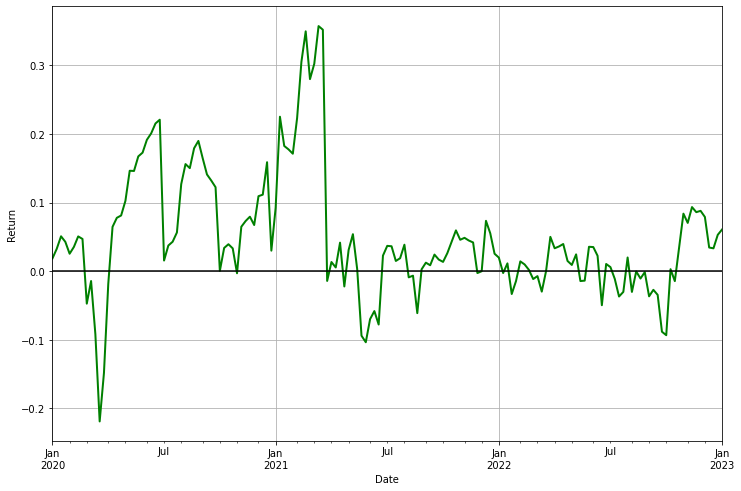

In [30]:
# визуалзиация на процентной доходности
part_retest_df = df_w_pct[NextDay(reDates[0]):reDates[1]]

for d in range(len(reDates)):
        try:
            retest_df = df_w_pct[NextDay(reDates[d]):reDates[d+1]]
        except:
            retest_df = df_w_pct[NextDay(reDates[d]):]
        if d == 0:
            retest_din = np.matmul(retest_df, rePortfs[reDates[d]]).cumsum()
        else:        
            # re_train_din = np.matmul(df_w_pct[:'2021-12-31'], res.x).cumsum() # TRAIN 2020-2021
            retest_din = pd.concat([retest_din, np.matmul(retest_df, rePortfs[reDates[d]]).cumsum()])

plt.figure(figsize=(12,8))
retest_din.plot(color='green', linewidth=2)
plt.ylabel('Return')
plt.grid()
plt.axhline(y=0, color='black')
plt.show()

In [36]:
# Доходность портфеля за период
print('Доходность портфеля за период {:.2%}'.format(retest_din[-1]))
# Шарп
print('Коэффициент Шарпа {:.2f}'.format(retest_din[-1] / retest_din.std()))

Доходность портфеля за период 6.07%
Коэффициент Шарпа 0.66


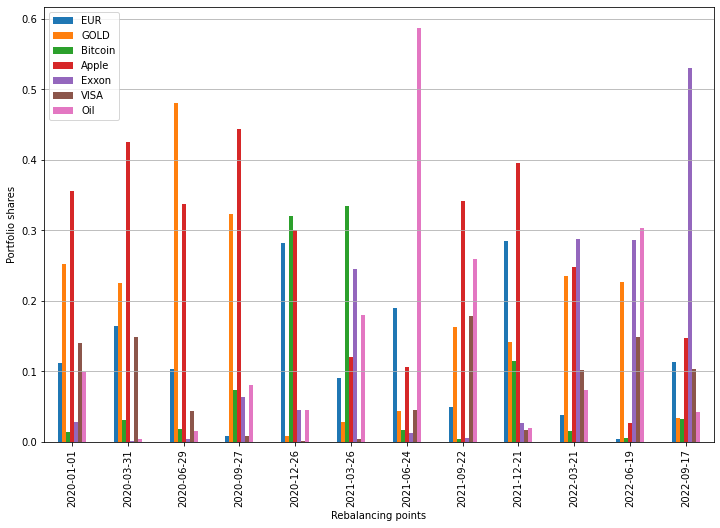

In [32]:
pd.DataFrame(rePortfs).T.plot(kind='bar', figsize=(12,8))
plt.legend(tickers)
plt.grid(axis='y')
plt.ylabel('Portfolio shares')
plt.xlabel('Rebalancing points')
plt.show()